In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("F:/Programming Analytics/AML/AML lab/5. KNN and iterative/train.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


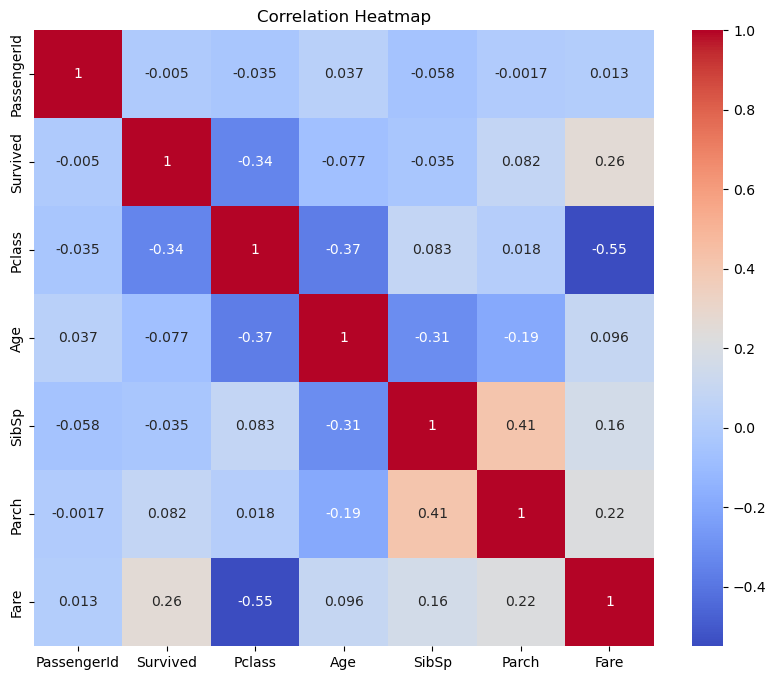

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

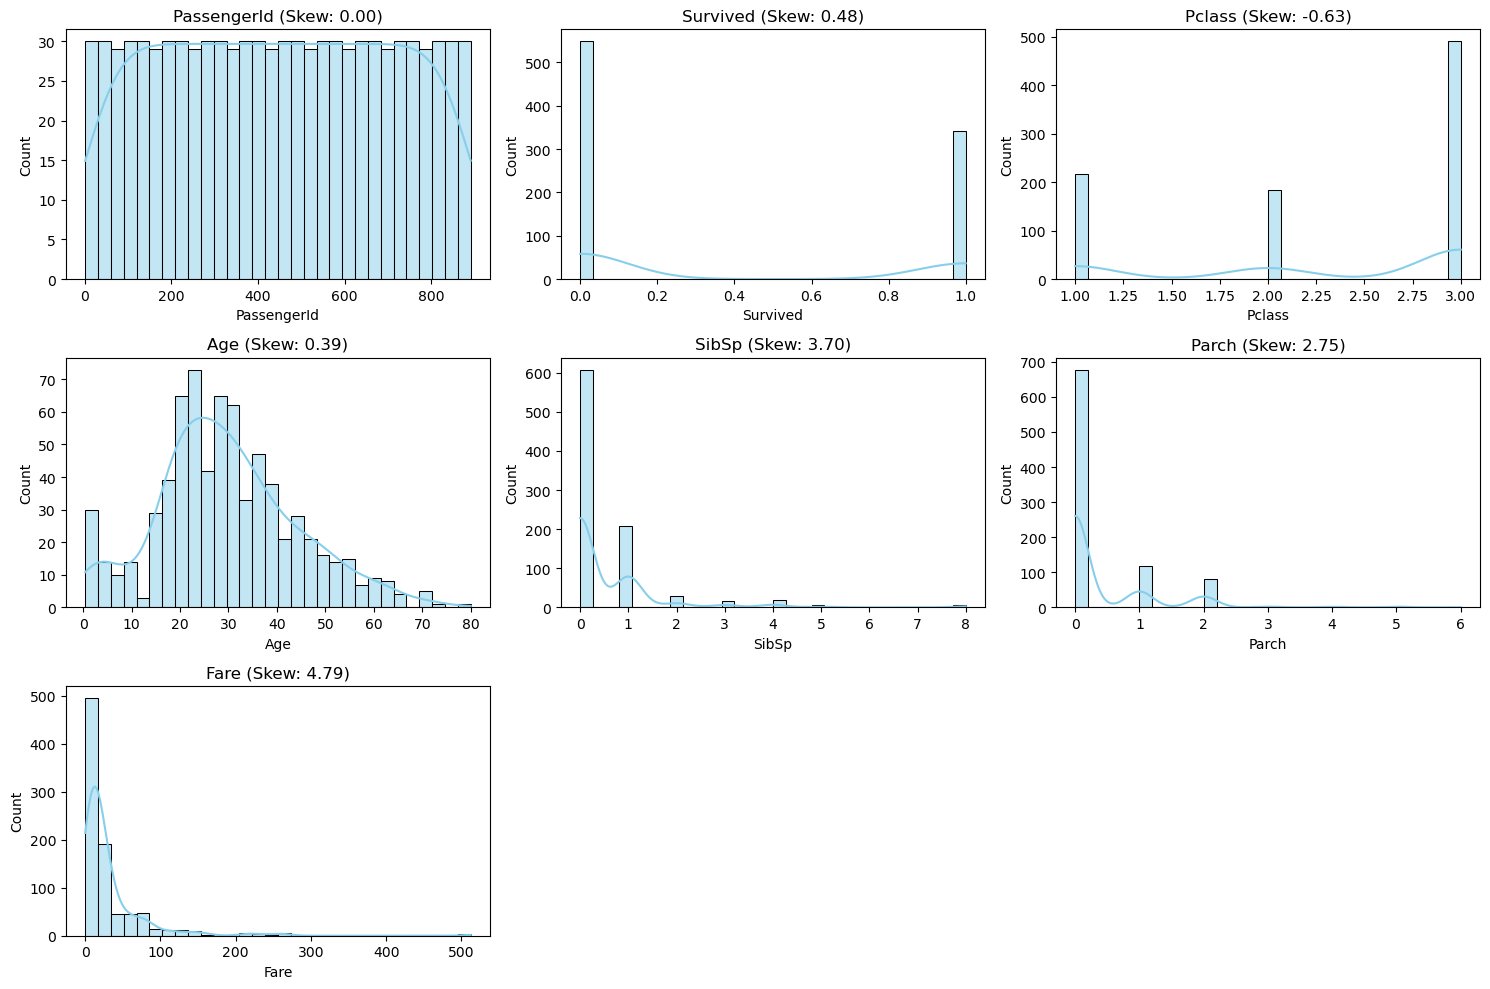

In [7]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"{col} (Skew: {df[col].skew():.2f})")
plt.tight_layout()
plt.show()

In [8]:
# =0 -> normal
# >0 -> right skewed
# <0 -> left skewed

In [10]:
df.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [11]:
# 1. Fill 'Age' with median (because it's skewed)
df['Age'] = df['Age'].fillna(df['Age'].median())

In [12]:
# 2. Fill 'Embarked' with mode (most common value)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [13]:
# 3. Fill missing Cabin with 'Unknown'
df['Cabin'] = df['Cabin'].fillna('Unknown')

# Create a binary column: 1 if Cabin known, 0 if Unknown
df['Cabin_Known'] = df['Cabin'].apply(lambda x: 0 if x == 'Unknown' else 1)


In [14]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Cabin_Known    0
dtype: int64

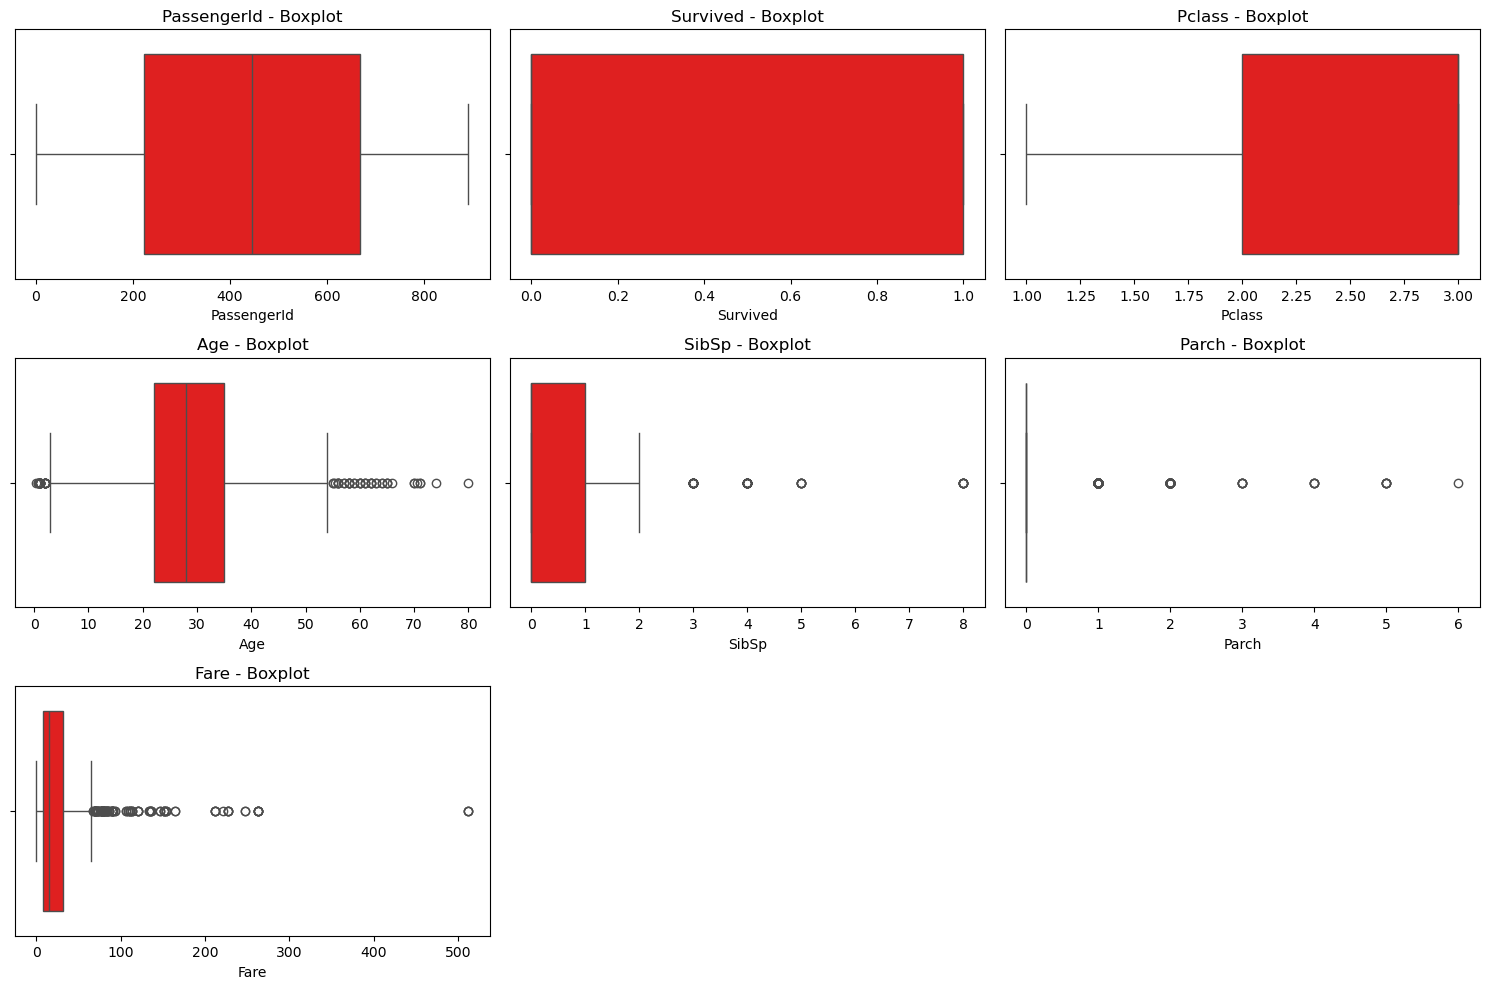

In [15]:
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//3+1, 3, i)
    sns.boxplot(x=df[col], color='red')
    plt.title(f"{col} - Boxplot")

plt.tight_layout()
plt.show()

In [16]:
import numpy as np

# IQR Capping for Age and Fare
for col in ['Age', 'Fare']:
    Q1 = df[col].quantile(0.25)  # 25th percentile
    Q3 = df[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the values
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                    np.where(df[col] > upper_bound, upper_bound, df[col]))

print(df[['Age', 'Fare']].describe())


              Age        Fare
count  891.000000  891.000000
mean    29.039282   24.046813
std     12.072074   20.481625
min      2.500000    0.000000
25%     22.000000    7.910400
50%     28.000000   14.454200
75%     35.000000   31.000000
max     54.500000   65.634400


In [17]:
target = 'Embarked'

# Split data into features (X) and target (y)
X = df.drop(columns=[target])
y = df[target]

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(exclude=['number']).columns

In [20]:
numeric_cols

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Cabin_Known'],
      dtype='object')

In [21]:
categorical_cols

Index(['Name', 'Sex', 'Ticket', 'Cabin'], dtype='object')

In [23]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [25]:
X_train, X_test = X_train_scaled, X_test_scaled

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Separate features and target
X = df.drop(target, axis=1)
y = df[target]

# Encode string columns
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

if y.dtype == 'object':
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to try
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Compare models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

Logistic Regression Accuracy: 68.72%
              precision    recall  f1-score   support

           0       0.75      0.14      0.24        43
           1       0.00      0.00      0.00        17
           2       0.68      0.98      0.81       119

    accuracy                           0.69       179
   macro avg       0.48      0.37      0.35       179
weighted avg       0.64      0.69      0.59       179

--------------------------------------------------
Decision Tree Accuracy: 84.36%
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        43
           1       0.75      0.88      0.81        17
           2       0.88      0.89      0.88       119

    accuracy                           0.84       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.84      0.84      0.84       179

--------------------------------------------------
Random Forest Accuracy: 85.47%
              precision    recall  f1

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# # Encode categorical features in X
# X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale only numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Mean Squared Error (MSE): 0.66
Root Mean Squared Error (RMSE): 0.81
Mean Absolute Error (MAE): 0.66
R-squared (R2): 0.09
